In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [3]:
## These are for the interactive plot in this notebook.
# You may have to install the packages first (use pip or conda install)
# Also fine to skip it, if you don't want to run the plot.

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

<div style="background-color: rgba(0, 176, 176, 1); color: rgba(255, 255, 255, 1); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Load data
</div>

In [95]:
## load original dataset with interpolated SPOSTMIN
df_itp = pd.read_csv('../data/clean/posted_interpolated.csv')
print(len(df_itp))
df_itp.head()

4117190


,attraction,date,minute,SPOSTMIN
0,7_dwarfs_train,2015-01-01,0,0.0
1,7_dwarfs_train,2015-01-01,30,0.0
2,7_dwarfs_train,2015-01-01,60,0.0
3,7_dwarfs_train,2015-01-01,90,0.0
4,7_dwarfs_train,2015-01-01,120,0.0


In [47]:
## load original dataset SACTMIN
df_act = pd.read_csv('../data/clean/actuals_shifted.csv')
print(len(df_act))
df_act.head()

192372


,attraction,date,datetime,SACTMIN,minute
0,7_dwarfs_train,2015-01-01,2015-01-01 08:05:30,54.0,485
1,7_dwarfs_train,2015-01-01,2015-01-01 08:22:16,55.0,502
2,barnstormer,2015-01-01,2015-01-01 10:39:48,18.0,639
3,big_thunder_mtn,2015-01-01,2015-01-01 14:55:16,37.0,895
4,buzz_lightyear,2015-01-01,2015-01-01 10:24:25,69.0,624


In [60]:
## load training dataest
df = pd.read_csv('../data/clean/training_dataset.csv')
print(len(df))
df.head()


183488


,minute,attraction,date,actual_over_posted
0,485,7_dwarfs_train,2015-01-01,0.900000
1,502,7_dwarfs_train,2015-01-01,0.916667
2,639,barnstormer,2015-01-01,0.900000
3,895,big_thunder_mtn,2015-01-01,0.528571
4,624,buzz_lightyear,2015-01-01,1.061538


In [7]:
## Load metadata
df_meta = pd.read_csv('../data/overview data/metadata.csv', sep = ',', usecols=['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR','SEASON'])
df_meta.sample(5)

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON
450,03/26/2016,7,85,12,3,2016,EASTER
37,02/07/2015,7,37,5,2,2015,WINTER
608,08/31/2016,4,243,35,8,2016,SEPTEMBER LOW
915,07/04/2017,3,184,27,7,2017,JULY 4TH
855,05/05/2017,6,124,18,5,2017,SPRING


<div style="background-color: rgba(0, 176, 176, 1); color: rgba(255, 255, 255, 1); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Cleaning - Merging
</div>

In [61]:
## Check quality of actual_over_posted values
print(f"NaN count: {df['actual_over_posted'].isna().sum()}")  
print(f"Zero count: {df['actual_over_posted'].isnull().sum()}")
print(f"Inf count: {(~np.isfinite(df['actual_over_posted'])).sum()}")

NaN count: 0
Zero count: 0
Inf count: 172


In [62]:
## cleaning: remove 'inf' in actual_over_posted
pre = len(df)
df = df[np.isfinite(df['actual_over_posted'])]
print(f"Removed {pre - len(df)} rows.")

Removed 172 rows.


In [10]:
# ## Fill NaN with the value 'NONE'
# df_meta['SEASON']=df_meta['SEASON'].fillna(value='NO_SEASON')

In [11]:
# # Merge df_meta into df
# merged_df = pd.merge(df, df_meta, left_on='date', right_on='DATE', how='inner')
# print(len(df))
# len(merged_df)

In [96]:
# Change format of date columns
df['date'] = pd.to_datetime(df['date'])
df_itp['date'] = pd.to_datetime(df_itp['date'])
df_act['date'] = pd.to_datetime(df_act['date'])
df_meta['DATE'] = pd.to_datetime(df_meta['DATE'], format='%m/%d/%Y')

In [87]:
# Function to extract Features
def extract_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

In [65]:
# Extract features of the dataframe
extract_features(df)
df.sample(5)

,minute,attraction,date,actual_over_posted,year,month,day,day_of_week,week_of_year,quarter,day_of_year,is_weekend
179088,786,laugh_floor,2021-11-24,4.000000,2021,11,24,2,47,4,328,0
64062,552,rock_n_rollercoaster,2018-02-25,0.533333,2018,2,25,6,8,1,56,1
126893,679,dinosaur,2021-03-10,0.709091,2021,3,10,2,10,1,69,0
141014,665,toy_story_mania,2021-05-12,0.742857,2021,5,12,2,19,2,132,0
26031,625,haunted_mansion,2016-03-21,1.166667,2016,3,21,0,12,1,81,0


In [42]:
df.sample(5).to_csv("../data/clean/example_features.csv")

In [97]:
# Extract features of the interpolated df
extract_features(df_itp)
df_itp.sample(5)

,attraction,date,minute,SPOSTMIN,year,month,day,day_of_week,week_of_year,quarter,day_of_year,is_weekend
1572429,big_thunder_mtn,2017-09-14,1020,30.0,2017,9,14,3,37,3,257,0
3860995,7_dwarfs_train,2021-08-21,1500,0.0,2021,8,21,5,33,3,233,1
1093229,philharmagic,2016-12-07,1470,10.0,2016,12,7,2,49,4,342,0
2598093,dinosaur,2019-03-16,90,0.0,2019,3,16,5,11,1,75,1
2873008,rock_n_rollercoaster,2019-08-02,840,90.0,2019,8,2,4,31,3,214,0


In [58]:
# Extract features of the actuals df
extract_features(df_act)
df_act.sample(5)

,attraction,date,datetime,SACTMIN,minute,year,month,day,day_of_week,week_of_year,quarter,day_of_year,is_weekend
111382,buzz_lightyear,2020-01-09,2020-01-09 10:00:24,10.0,600,2020,1,9,3,2,1,9,0
31584,big_thunder_mtn,2016-05-24,2016-05-24 11:00:59,50.0,660,2016,5,24,1,21,2,145,0
65607,soarin,2018-01-18,2018-01-18 10:00:12,14.0,600,2018,1,18,3,3,1,18,0
37031,under_the_sea,2016-09-04,2016-09-04 12:21:24,38.0,741,2016,9,4,6,35,3,248,1
107932,flight_of_passage,2019-11-03,2019-11-03 09:00:04,157.0,540,2019,11,3,6,44,4,307,1


<div style="background-color: rgba(0, 176, 176, 1); color: rgba(255, 255, 255, 1); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Basic visualization
</div>

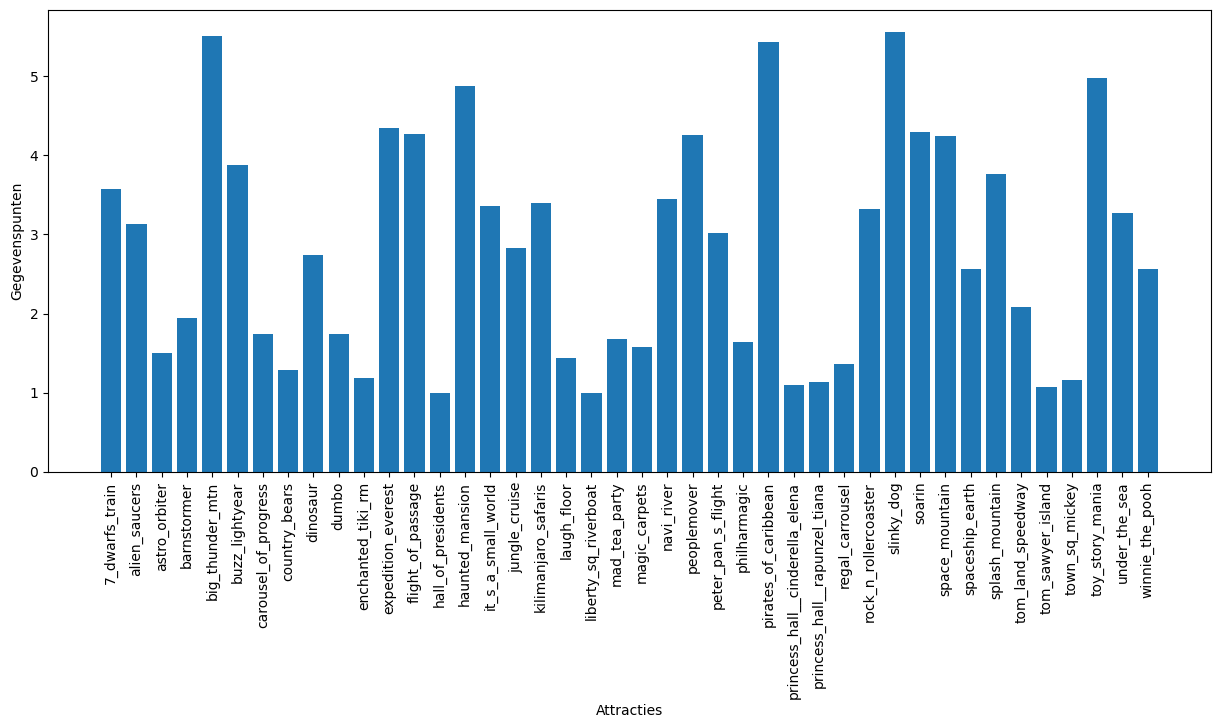

In [66]:
## How many target datapoints do we have per attraction?
posted_count = df.groupby(["attraction", "date"])["actual_over_posted"].count().reset_index()

avg_posted_count = posted_count.groupby("attraction")["actual_over_posted"].mean().reset_index()

plt.figure(figsize=(15, 6))
plt.bar(avg_posted_count["attraction"], avg_posted_count["actual_over_posted"])

plt.xlabel("Attracties")
plt.ylabel("Gegevenspunten")
plt.xticks(rotation=90)

plt.show()

<div style="background-color: rgba(0, 176, 176, 1); color: rgba(255, 255, 255, 1); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Model training
</div>

In [98]:
X = pd.get_dummies(df.drop(['actual_over_posted','date'],axis=1),drop_first=True)
y = df['actual_over_posted']

In [99]:
X.head(10)

,minute,year,month,day,day_of_week,week_of_year,quarter,day_of_year,is_weekend,attraction_alien_saucers,...,attraction_soarin,attraction_space_mountain,attraction_spaceship_earth,attraction_splash_mountain,attraction_tom_land_speedway,attraction_tom_sawyer_island,attraction_town_sq_mickey,attraction_toy_story_mania,attraction_under_the_sea,attraction_winnie_the_pooh
0,485,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
1,502,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
2,639,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
3,895,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
4,624,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
5,876,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
6,1265,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
7,519,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
8,593,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
9,568,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [101]:
# Function to fit a model and print metrics
def run_model(model,X_train,y_train,X_test,y_test):
    # Fitten van het Model
    model.fit(X_train,y_train)
    
    # Bereken de Metrics    
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'MAE : {mae}')
    print(f'RMSE : {rmse}')
    print(f"R²: {r2}")


In [102]:
## Let's try linear regression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

MAE : 0.2908137874406231
RMSE : 0.4274082332414929
R²: 0.05457039743328007


In [72]:
## Let's try random forest
model_rf = RandomForestRegressor(n_estimators=10)    
run_model(model_rf,X_train,y_train,X_test,y_test)

MAE : 0.2759609188961148
RMSE : 0.41800843521804765
R²: 0.0956979396647133


In [75]:
## Let's try Adaboost
model_ada = AdaBoostRegressor()
run_model(model_ada,X_train,y_train,X_test,y_test)

MAE : 1.5456131701666356
RMSE : 1.893910035954588
R²: -17.563596487352772


In [103]:
## Choose one of the models above to continue with?
model = model_lr       # Adapt as you prefer. 

<div style="background-color: rgba(0, 176, 176, 1); color: rgba(255, 255, 255, 1); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Check results
</div>

In [104]:
# prepare a dataframe with the same feature columns as the test set, selecting from the original dataset
df_itp_dummies = pd.get_dummies(df_itp)
feature_names = X.columns
df_features = df_itp_dummies[[col for col in feature_names if col in df_itp_dummies.columns]]


In [105]:
df_features.head()

,minute,year,month,day,day_of_week,week_of_year,quarter,day_of_year,is_weekend,attraction_alien_saucers,...,attraction_soarin,attraction_space_mountain,attraction_spaceship_earth,attraction_splash_mountain,attraction_tom_land_speedway,attraction_tom_sawyer_island,attraction_town_sq_mickey,attraction_toy_story_mania,attraction_under_the_sea,attraction_winnie_the_pooh
0,0,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
1,30,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
2,60,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
3,90,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
4,120,2015,1,1,3,1,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False


In [77]:
df_features.sample(5).to_csv("../data/clean/example_before_prediction.csv")

In [106]:
# Use the trained model to predict the ratio
df_itp['predicted_ratio'] = model.predict(df_features)
# Then predict the actual times by multiplying SPOSTMIN with the predicted ratio
df_itp['predicted_actual_time'] = df_itp['predicted_ratio'] * df_itp['SPOSTMIN']

In [79]:
df_itp.sample(5).to_csv("../data/clean/example_with_prediction.csv")

In [107]:
# Concatenate the actuals
concatenated_df = pd.concat([df_itp, df_act.drop(columns=['datetime'])], ignore_index=True, sort=False)
# Reindexing the DataFrame
concatenated_df = concatenated_df.reset_index(drop=True)

concatenated_df.sample(5)

,attraction,date,minute,SPOSTMIN,year,month,day,day_of_week,week_of_year,quarter,day_of_year,is_weekend,predicted_ratio,predicted_actual_time,SACTMIN
3979286,alien_saucers,2021-10-22,1080,20.0,2021,10,22,4,42,4,295,0,0.740937,14.818730,NaN
463235,mad_tea_party,2015-10-26,750,20.0,2015,10,26,0,44,4,299,0,0.704434,14.088676,NaN
2044993,princess_hall__rapunzel_tiana,2018-06-04,1140,40.0,2018,6,4,0,23,2,155,0,0.789238,31.569518,NaN
2103420,peter_pan_s_flight,2018-07-05,0,0.0,2018,7,5,3,27,3,186,0,0.907660,0.000000,NaN
606471,mad_tea_party,2016-01-25,1230,5.0,2016,1,25,0,4,1,25,0,0.633416,3.167082,NaN


In [108]:
# Initialize Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Predicted Waiting Times", style={'textAlign': 'center'}),
    
    # Dropdown for selecting Year
    html.Label("Select year:"),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in concatenated_df['year'].unique()],
        value=concatenated_df['year'].unique()[0],  # Default to first date
        clearable=False
    ),
        
    # Dropdown for selecting Month
    html.Label("Select month:"),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': month, 'value': month} for month in concatenated_df['month'].unique()],
        value=concatenated_df['month'].unique()[0],  # Default to first date
        clearable=False
    ),    
    
    # Dropdown for selecting Day
    html.Label("Select day:"),
    dcc.Dropdown(
        id='day-dropdown',
        options=[{'label': day, 'value': day} for day in concatenated_df['day'].unique()],
        value=concatenated_df['day'].unique()[0],  # Default to first date
        clearable=False
    ),
    
    # Dropdown for selecting Attraction
    html.Label("Select Attraction:"),
    dcc.Dropdown(
        id='attraction-dropdown',
        options=[{'label': attraction, 'value': attraction} for attraction in concatenated_df['attraction'].unique()],
        value=concatenated_df['attraction'].unique()[0],  # Default to first attraction
        clearable=False
    ),
    
    # Graph output
    dcc.Graph(id='scatter-plot')
])

# Callback to update graph based on selections
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('year-dropdown', 'value'),
     Input('month-dropdown', 'value'),
     Input('day-dropdown', 'value'),
     Input('attraction-dropdown', 'value')]
)
def update_graph(selected_year, selected_month, selected_day, selected_attraction):
    # Filter dataset
    filtered_df = concatenated_df.query("year == @selected_year \
                               & month == @selected_month \
                               & day == @selected_day \
                               & attraction == @selected_attraction")
    
    # Create scatter plot
    fig = px.scatter(
        filtered_df,
        x='minute',
        y=['SPOSTMIN','SACTMIN'],
        labels={'value': "Wait Time (Minutes)", 'minute': "Minute of the Day"},
        title=f"Wait Time for {selected_attraction} on {selected_year} - {selected_month} - {selected_day}"
    )

    # Add predicted_ratio curve
    fig.add_scatter(x=filtered_df['minute'], y=filtered_df['predicted_actual_time'],
                    mode='lines', name='Predicted', line=dict(color='green', width=2))
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [30]:
## Prepare export dataset
# Select required columns
export_df = concatenated_df[['attraction', 'date', 'minute', 'SPOSTMIN', 'SACTMIN', 'predicted_actual_time']]

In [31]:
# Export as csv
export_df.to_csv('../data/clean/waiting_times_with_prediction.csv')

<div style="background-color: rgba(0, 176, 176, 1); color: rgba(255, 255, 255, 1); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Prepare report on regression model
</div>

In [110]:
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

print(coefficients)

                                       Feature   Coefficient  Abs_Coefficient
37                  attraction_regal_carrousel  5.201762e-01     5.201762e-01
18                attraction_enchanted_tiki_rm  5.173747e-01     5.173747e-01
26                      attraction_laugh_floor  3.122587e-01     3.122587e-01
21               attraction_hall_of_presidents  2.748791e-01     2.748791e-01
10                    attraction_astro_orbiter  2.402902e-01     2.402902e-01
46                   attraction_town_sq_mickey  2.100713e-01     2.100713e-01
42                  attraction_spaceship_earth -1.909229e-01     1.909229e-01
33                     attraction_philharmagic  1.771334e-01     1.771334e-01
13                   attraction_buzz_lightyear -1.366578e-01     1.366578e-01
35  attraction_princess_hall__cinderella_elena  1.356351e-01     1.356351e-01
22                  attraction_haunted_mansion -1.296151e-01     1.296151e-01
15                    attraction_country_bears  1.009303e-01    

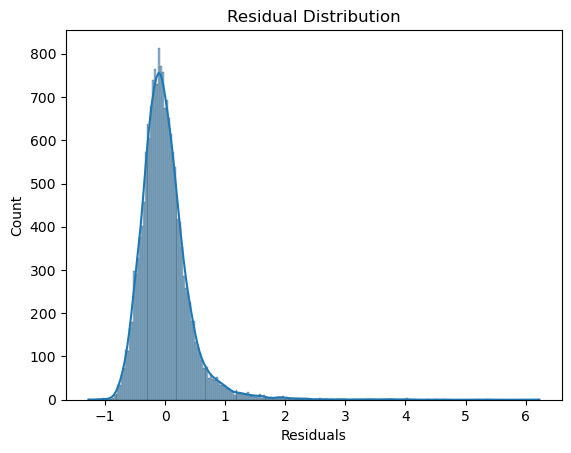

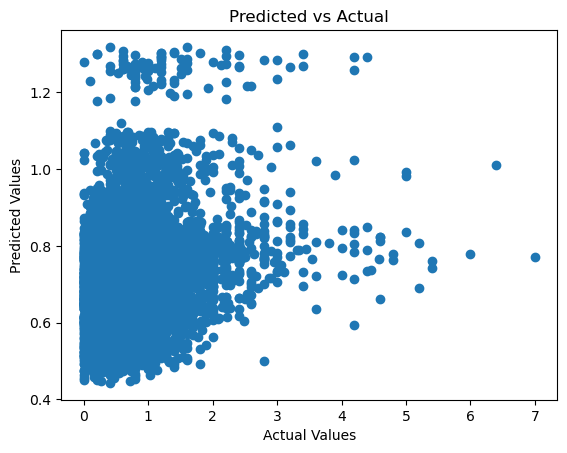

In [109]:
# Residuals plot
preds = model.predict(X_test)
residuals = y_test - preds
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

# Predicted vs Actual
plt.scatter(y_test, preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.show()
